# Depth First CNN

Supports both depth-first and standard breadth-first 2d convolutions. To use depth-first mode, you must pass in a position to sample for each iteration, and you must iterate manually.

This is intended for use in autoregressive CNNs. Using the breadth-first method is faster for training, but the depth-first method is faster for sampling (because it only processes the element under question, caching all results for the next iteration).

The technique sacrifices memory efficiency for raw speed.

Convolutions must be causal for recurrent sampling parity, but non recurrent parity is acheived regardless of causality, though this is likely less useful.

In [1]:
import abc
import datetime
import timeit
from dataclasses import dataclass
from typing import Optional

import matplotlib.colors as clr
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.version
from torch import Tensor


## Numerical Stability

We need to take some extra precautions to ensure numerical stability.

In [2]:
def stable_softmax(x: Tensor, dim: int = -1, keepdim: bool = True) -> Tensor:
    if x.numel() == 0:
        return torch.empty_like(x)
    x = x - x.max()
    return torch.log_softmax(x, -1)


## DfModule

An abstract module to support depth-first forward

In [3]:
class DfModule(abc.ABC, nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._cache: Optional[Tensor] = None

    @abc.abstractmethod
    def b_forward(self, *img: Tensor) -> Tensor:
        raise

    @abc.abstractmethod
    def d_forward(
        self, *img: Tensor, pos: tuple[int, int], clear_cache: bool
    ) -> Tensor:
        raise

    def forward(
        self,
        *img: Tensor,
        pos: Optional[tuple[int, int]] = None,
        clear_cache: bool = False,
    ) -> Tensor:
        if pos == None:
            return self.b_forward(*img)
        else:
            return self.d_forward(*img, pos=pos, clear_cache=clear_cache)

    def __call__(
        self,
        *img: Tensor,
        pos: Optional[tuple[int, int]] = None,
        clear_cache: bool = False,
    ) -> Tensor:
        return self.forward(*img, pos=pos, clear_cache=clear_cache)


## DfElemWise

A basic wrapper module to make element-wise operations (e.g. activation functions) depth-first.

In [4]:

class DfElemwise(DfModule):
    def __init__(self, module: nn.Module) -> None:
        super().__init__()
        self._module = module
        self._cache: Optional[Tensor] = None

    def b_forward(self, img: Tensor) -> Tensor:
        return self._module(img)

    def d_forward(
        self, img: Tensor, pos: tuple[int, int], clear_cache: bool
    ) -> Tensor:
        if clear_cache or self._cache == None or pos == (0, 0):
            self._cache = torch.zeros_like(img)
        y, x = pos
        self._cache[..., y, x] = self._module(img[..., y, x])
        return self._cache


## DfConv2d

Defines a basic 2d convolution that supports depth-first forward.

In [5]:
class DfConv2d(DfModule):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        masked: bool = True,
        device: Optional[torch.device | str] = None,
        dtype: Optional[torch.dtype] = None,
    ) -> None:
        super().__init__()
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._kernel_size = kernel_size
        self._masked = masked
        self._device = device
        self._dtype = dtype
        self._cache: Optional[Tensor] = None

        self.weight = nn.Parameter(
            torch.randn(
                out_channels,
                in_channels,
                kernel_size,
                kernel_size,
                dtype=dtype,
                device=device,
            )
        )

    def b_forward(self, img: Tensor) -> Tensor:
        padding = self._kernel_size // 2
        return F.conv2d(img, self.weight, padding=padding)

    def d_forward(self, img: Tensor, pos: tuple[int, int], clear_cache: bool) -> Tensor:
        kernel_size = self._kernel_size
        padding = kernel_size // 2

        if clear_cache or self._cache == None or self._padded == None or pos == (0, 0):
            self._cache = torch.zeros(
                img.shape[0],
                self._out_channels,
                *img.shape[2:],
                dtype=img.dtype,
                device=img.device,
            )
            self._padded = F.pad(img, [padding] * 4, mode="constant", value=0)

        y, x = pos
        startp = None if padding == 0 else padding
        endp = None if padding == 0 else -padding
        self._padded[..., startp:endp, startp:endp] = img
        patch = self._padded[..., y : y + kernel_size, x : x + kernel_size]

        out: Tensor = F.conv2d(patch, self.weight)
        self._cache[..., y, x] = out.squeeze()
        return self._cache

    def forward(
        self,
        img: Tensor,
        pos: Optional[tuple[int, int]] = None,
        clear_cache: bool = False,
    ) -> Tensor:
        if self._masked:
            padding = self._kernel_size // 2
            self.weight.data[..., padding + 1 :, :] = 0
            self.weight.data[..., padding, padding:] = 0

        return super().forward(img, pos=pos, clear_cache=clear_cache)


## DfAttention

A depth-first capable self attention module. Uses DfConv2d for it's convolutions, and also only runs the minimum necessary attention computations.

```python
i = (y * width) + x
attn = q[..., :i, :] @ k[..., i : i+1]
px = v[..., :i] @ attn
```
<img src="assets/attention.png" alt="attention" width="50%">


In [6]:
class DfAttention(DfModule):
    def __init__(
        self,
        channels: int,
        key_dim: Optional[int] = None,
        device: Optional[torch.device | str] = None,
        dtype: Optional[torch.dtype] = None,
    ) -> None:
        super().__init__()
        self._channels = channels
        if key_dim == None:
            key_dim = channels // 8
        self._key_dim = key_dim

        self._conv = DfConv2d(channels, 2 * key_dim + channels, 1, device=device, dtype=dtype)
        self._gamma = nn.Parameter(torch.zeros(1, device=device, dtype=dtype))
        self._cache: Optional[Tensor] = None

    def qet_qkv(self, img: Tensor, pos: Optional[tuple[int, int]], clear_cache: bool) -> tuple[torch.Size, Tensor, Tensor, Tensor]:
        shape = img.shape
        qkv = self._conv(img, pos=pos, clear_cache=clear_cache)
        q, k, v = (
            t.view(*t.shape[:-2], -1)
            for t in qkv.split_with_sizes([self._key_dim] * 2 + [self._channels], -3)
        )

        return shape, q, k, v


    def b_forward(self, img: Tensor) -> Tensor:
        shape, q, k, v = self.qet_qkv(img, None, False)
        attn = stable_softmax(torch.bmm(q.transpose(-2, -1), k))
        attn.triu(1)
        out = torch.bmm(v, attn).view(*shape).contiguous()
        return out + img


    def d_forward(
        self, img: Tensor, pos: tuple[int, int], clear_cache: bool
    ) -> Tensor:
        if self._cache == None or pos == (0, 0) or clear_cache:
            self._cache = torch.zeros_like(img)

        shape, q, k, v = self.qet_qkv(img, pos, clear_cache)
        i = (pos[0] * shape[-1]) + pos[1]
        attn = stable_softmax(torch.bmm(q[..., :i].transpose(-2, -1), k[..., i:i+1]))
        px = torch.bmm(v[..., :i], attn)
        self._cache[..., pos[0], pos[1]] = img[..., pos[0], pos[1]] + px.squeeze()
        return self._cache



attn = DfAttention(64)
attn(torch.randn(1, 64, 8, 8), pos=(7, 7), clear_cache=True).shape


torch.Size([1, 64, 8, 8])

### Check the parity of a single random pixel

You can adjust various parameters to see how it compares between devices / dtypes.

In [7]:
with torch.no_grad():
    device1 = "cuda"
    device2 = "cuda"

    dtype1 = torch.float32
    dtype2 = torch.float32

    method1 = "depth"
    method2 = "breadth"

    hidden_channels = 64
    size = (32, 32)
    position = (31, 31)

    input = torch.randn(8, hidden_channels, *size)

    seed = torch.seed()
    input1 = input.to(device1, dtype1)
    mod1 = DfConv2d(
        hidden_channels, hidden_channels, 3, device=device1, dtype=dtype1
    ).eval()
    # mod1 = DfAttention(
    #     hidden_channels, device=device1, dtype=dtype1
    # ).eval()
    out1 = mod1(input1, pos=position if method1 == "depth" else None, clear_cache=True)[
        ..., position[0], position[1]
    ]
    out1 = out1.to(device1, dtype1)

    torch.manual_seed(seed)
    input2 = input.to(device2, dtype2)
    mod2 = DfConv2d(
        hidden_channels, hidden_channels, 3, device=device2, dtype=dtype2
    ).eval()
    # mod2 = DfAttention(
    #     hidden_channels, device=device2, dtype=dtype2
    # ).eval()
    out2 = mod2(input2, pos=position if method2 == "depth" else None, clear_cache=True)[
        ..., position[0], position[1]
    ]
    out2 = out2.to(device1, dtype1)

    if torch.equal(out1, out2):
        print("Exactly equal")
    else:
        if torch.allclose(out1, out2):
            print("Close enough according to PyTorch defaults")
        else:
            print("Not close at all")
        max_diff = (out1.to(device1, dtype1) - out2.to(device1, dtype1)).abs().max()
        print(f"Maximum difference: {max_diff:.5f}")


Exactly equal


### Sample

Defines a very basic autoregressive network and sampling process.

In [8]:
@torch.no_grad()
def sample(
    depth_first: bool,
    device: str = "cuda",
    dtype: torch.dtype = torch.float32,
    batch_size: int = 16,
    img_size: int = 64,
    in_channels: int = 3,
    hidden_channels: int = 64,
    num_classes: int = 256,
    kernel_size: int = 3,
    seed: Optional[int] = None,
) -> tuple[Tensor, int]:
    if seed == None:
        seed = torch.seed()
    else:
        torch.manual_seed(seed)

    img = (
        torch.randint(
            0,
            num_classes,
            (batch_size, in_channels, img_size, img_size),
            dtype=dtype,
            device=device,
        )
        / num_classes
    )

    conv_in = DfConv2d(
        in_channels,
        hidden_channels,
        kernel_size,
        device=device,
        dtype=dtype,
        masked=True,
    ).eval()
    act_in = DfElemwise(nn.ReLU())

    conv_hid = DfConv2d(
        hidden_channels,
        hidden_channels,
        kernel_size,
        device=device,
        dtype=dtype,
        masked=True,
    ).eval()
    act_hid = DfElemwise(nn.ReLU())

    attn = DfAttention(hidden_channels, device=device, dtype=dtype)

    conv_out = DfConv2d(
        hidden_channels,
        num_classes * in_channels,
        kernel_size=1,
        device=device,
        dtype=dtype,
        masked=False,
    ).eval()
    act_out = DfElemwise(nn.ReLU())

    for y in range(img_size):
        for x in range(img_size):
            pos = (y, x) if depth_first else None
            o = conv_in(img, pos=pos)
            o = act_in(o, pos=pos)

            o = conv_hid(o, pos=pos)
            o = act_hid(o, pos=pos)

            o = attn(o, pos=pos)

            o = conv_out(o, pos=pos)
            o = act_out(o, pos=pos)

            px = (
                o[..., y, x].view(batch_size, in_channels, num_classes).argmax(-1)
                / num_classes
            ) + 1e-15

            img[..., y, x] = px

    plt.imshow(img[0].to(torch.float32).permute(1, 2, 0).cpu(), norm=clr.Normalize())
    return img, seed


In [9]:
# Just abstracting some stuff to make timed sampling convenient


@dataclass
class Ctx:
    img: Optional[Tensor] = None
    seed: Optional[int] = None


ctx = Ctx()


def get_callable(depth_first: bool, ctx: Ctx = ctx):
    def call():
        ctx.img, ctx.seed = sample(depth_first=depth_first, seed=ctx.seed)

    return call


def tsdelta(seconds: float) -> datetime.timedelta:
    return datetime.datetime.fromtimestamp(seconds) - datetime.datetime.fromtimestamp(0)


def strfdelta(tdelta: datetime.timedelta | float, fmt: str) -> str:
    if isinstance(tdelta, (float, int)):
        tdelta = tsdelta(tdelta)
    hours, rem = divmod(tdelta.seconds, 60 * 60)
    minutes, seconds = divmod(rem, 60)
    return fmt.format(d=tdelta.days, h=hours, m=minutes, s=seconds)


def fmttime(time: float) -> str:
    return strfdelta(time, "{h:02}:{m:02}:{s:.2f}")


#### Depth First

Runs the sampler depth-first

Sample took 00:00:3.00 to complete


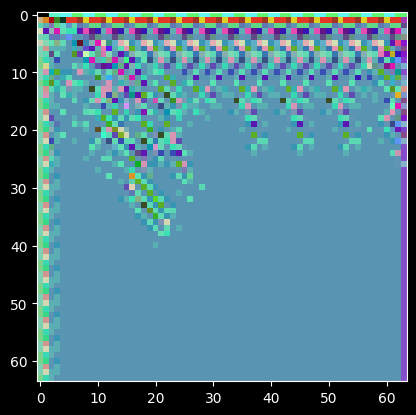

In [10]:
time = timeit.timeit(get_callable(True), number=1)
img_d = ctx.img
print(f"Sample took {fmttime(time)} to complete")


#### Breadth First

Runs the sampler breadth-first

Sample took 00:02:17.00 to complete


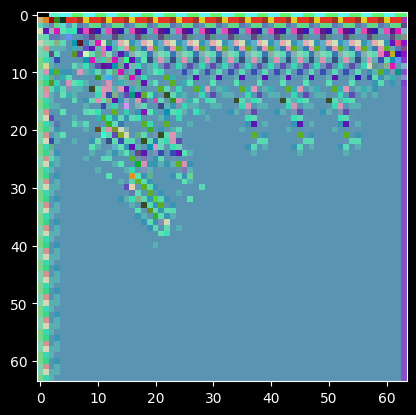

In [11]:
time = timeit.timeit(get_callable(False), number=1)
img_b = ctx.img
print(f"Sample took {fmttime(time)} to complete")


#### Verify Parity

Verifies the parity between the depth-first and breadth-first methods.

PyTorch may process slices vs complete batches slightly differently, leading to minor differences in output at each layer. These differences will accumulate through the forward pass and cause the 2 methods to diverge if the depth-first approach doesn't have a large enough batch-size / channel depth.

> In particular, let A and B be 3D tensors with the dimensions suitable for batched matrix multiplication. Then (A@B)[0] (the first element of the batched result) is not guaranteed to be bitwise identical to A[0]@B[0] (the matrix product of the first elements of the input batches) even though mathematically it’s an identical computation.
>
> https://pytorch.org/docs/stable/notes/numerical_accuracy.html#batched-computations-or-slice-computations



Samples are not close!


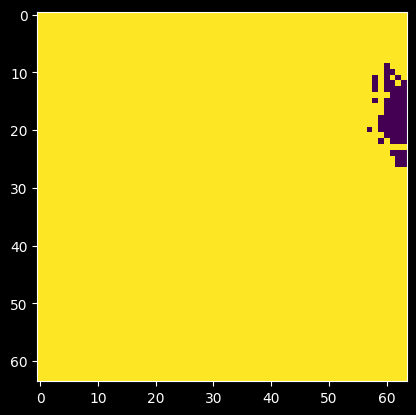

In [12]:
assert img_d is not None and img_b is not None

if torch.equal(img_d, img_b):
    print("Samples are exactly equal!")
elif torch.allclose(img_d, img_b):
    print("Samples are close enough according to PyTorch defaults!")
else:
    print("Samples are not close!")
    plt.imshow(
        torch.isclose(img_d, img_b).all(0).all(0, keepdim=True).permute(1, 2, 0).cpu(),
        norm=clr.Normalize(),
    )
